# Ручные задчки на рекурентные сетки

$$
y = 1, 2, 3
$$

$$w = 1, u = 1, v = 1$$

$$
f_h(z) = ReLu(0, z)
$$

$$
f_y(z) = ReLu(0, z)
$$

Нейронная сетка: 

$$
h_t = ReLU(w \cdot h_{t-1} + v \cdot y_{t})
$$

$$
y_{t+1} = ReLU(u \cdot h_t)
$$

$h_0 = 0$

\begin{equation*}
\begin{aligned}
&h_1 = f(w \cdot h_0 + v \cdot y_1) = f(1 \cdot 0 + 1 \cdot 1) = 1 \\
&\hat{y}_2= f(u \cdot h_1) = 1 \\
\end{aligned}
\end{equation*}

# Авокадо цены 

https://www.kaggle.com/neuromusic/avocado-prices

In [9]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

In [11]:
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [10]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [12]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [15]:
from sklearn.metrics import median_absolute_error, mean_absolute_error

In [79]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional


tf.__version__

'2.3.0'

In [22]:
df = pd.read_csv('avocado.csv', index_col=['Date'], parse_dates=['Date'])
print(df.shape)
df.head()

(18249, 13)


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-12-27,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


(338,)


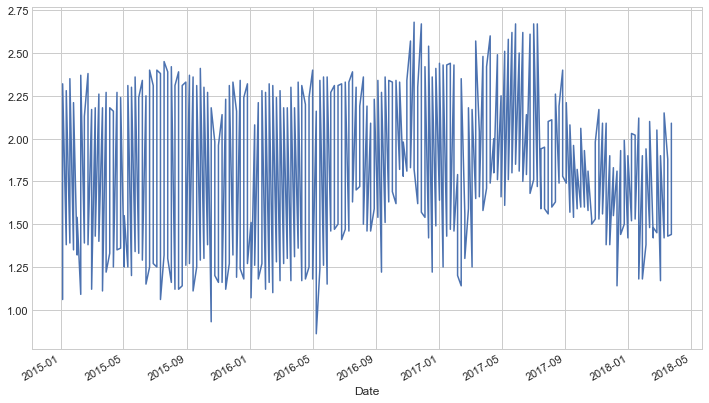

In [25]:
df = df[df.region == 'HartfordSpringfield']
avocado = df['AveragePrice']
print(avocado.shape)
avocado.plot(figsize=(12,7));

# Arima

In [34]:
import pmdarima as pm

arima_model = pm.auto_arima(avocado[:int(0.7*avocado.size)], 
                            start_p=1, max_p=3,
                            start_q=1, max_q=3,
                            m=12,
                            start_P=0, start_Q=0,
                            seasonal=True,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            max_d=1,
                            max_D=1)
arima_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [44]:
cv = pm.model_selection.SlidingWindowForecastCV(window_size=int(0.7*avocado.size), step=1, h=1)

predicts_Index = pm.model_selection.cross_val_predict(
    arima_model,
    avocado,
    cv=cv,
    #verbose=2,
    averaging="mean"
)

In [59]:
df_test = avocado[int(0.7*avocado.size):].reset_index()
df_test['hat'] = predicts_Index
df_test.set_index('Date', inplace=True)

mean_absolute_error(df_test['hat'], df_test['AveragePrice'])

0.15247499127538597

<AxesSubplot:xlabel='Date'>

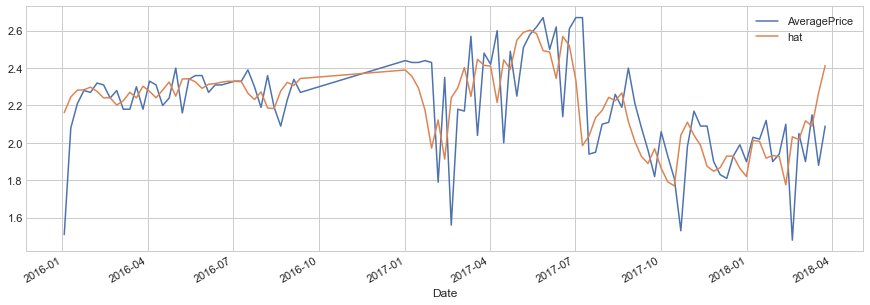

In [62]:
df_test.plot(figsize=(15,5))

# RNN 

Разрезание выборки для обучения. 

In [66]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [67]:
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# насколько сильно заглядывать в прошлое
n_steps = 5

# разбиение
X1, y1 = split_sequence(raw_seq, n_steps)
y1

array([60, 70, 80, 90])

In [69]:
X1

array([[10, 20, 30, 40, 50],
       [20, 30, 40, 50, 60],
       [30, 40, 50, 60, 70],
       [40, 50, 60, 70, 80]])

In [102]:
y = avocado.values
n_steps = 30

treshhold = int(0.7*avocado.size) - 30
X, y = split_sequence(y, n_steps)

y_train, X_train = y[:treshhold], X[:treshhold]
y_test, X_test = y[treshhold:], X[treshhold:]

In [103]:
X_train.shape

(206, 30)

In [104]:
# [samples, timesteps] => [samples, timesteps, features]

n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train.shape

(206, 30, 1)

In [105]:
model = Sequential()
model.add(LSTM(2, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [106]:
history = model.fit(X_train, y_train, epochs=200, batch_size=20, 
                    validation_split=0.2, shuffle=False, verbose=0)

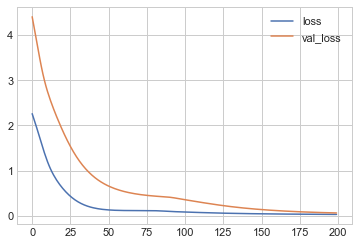

In [110]:
pd.DataFrame(history.history).plot();

In [108]:
X.shape

(308, 30)

Дальше нам стало лень делать кросс-валидацию по-честному и мы забили :) 

In [109]:
df_test['hat_lstm'] = model.predict(X_test).T[0]

<AxesSubplot:xlabel='Date'>

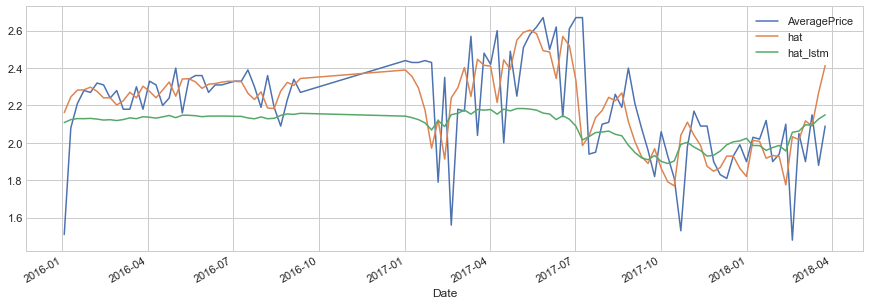

In [111]:
df_test.plot(figsize=(15,5))

In [112]:
mean_absolute_error(df_test['hat_lstm'], df_test['AveragePrice'])

0.19521773899302766